In [6]:
from scalability_testing import *
import re
import pandas as pd
import csv
from pyspark import StorageLevel
import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf, lower, count, regexp_replace, trim
from pyspark.sql.types import StringType, IntegerType
from collections import Counter
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

In [3]:
def sentiment_analysis(df, spark_context):

    botlist_path="/home/ubuntu/DEI-project/preprocessing/preprocessing files/botlist.csv"
    positive_words_file = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/positive_words.csv"
    negative_words_file = "/home/ubuntu/DEI-project/preprocessing/preprocessing files/negative_words.csv"

    ############################# Preprocessing #############################
    # Select relevant columns
    df = df.select("author", "subreddit", "normalizedBody")

    # Load bot list
    bot_df = pd.read_csv(botlist_path)
    bot_list = bot_df["AAbot"].dropna().unique().tolist() 

    # Remove bot-generated comments and posts missing text 
    df_filtered = df.filter(~col("author").isin(bot_list) & col("normalizedBody").isNotNull())

    # Remove special characters, convert to lowercase and trim spaces
    df_cleaned = df_filtered.withColumn(
        "normalizedBody",
        trim(lower(regexp_replace(col("normalizedBody"), r'[^a-zA-Z\s]', '')))
    ).drop("author") # dropt author column

    
    
    
    ############################ Sentiment Analysis ############################
    def load_words_from_csv(filepath):
        with open(filepath, "r") as file:
            lines = file.read().splitlines()  # read all lines at once
        
        lines = lines[1:]  # skip header

        return set(word.strip() for word in lines if word)  # remove empty lines

    positive_words = load_words_from_csv(positive_words_file)
    negative_words = load_words_from_csv(negative_words_file)

    # Broadcast word lists to all Spark workers
    positive_broadcast = spark_context.broadcast(positive_words)
    negative_broadcast = spark_context.broadcast(negative_words)

    # Define sentiment analysis function
    def analyze_sentiment(text):
        if not text:
            return 0 # neutral
        words = text.lower().split()

        # dictionary with word counts
        word_counts = Counter(words)
    
        # Count positive and negative words using intersection with the word counts
        pos_count = sum(word_counts[word] for word in words if word in positive_broadcast.value)
        neg_count = sum(word_counts[word] for word in words if word in negative_broadcast.value)

        # labeling with integers to simplify postive-to-negative calculations
        if pos_count > neg_count:
            return 1 # positive
        elif neg_count > pos_count:
            return -1 # negative
        return 0 # neutral
    
    # Register UDF
    sentiment_udf = udf(analyze_sentiment, IntegerType())

    # Apply sentiment analysis
    df_result = df_cleaned.withColumn("sentiment", sentiment_udf(col("normalizedBody")))

    # unpersist
    #df_cleaned.unpersist()
    
    ################## Finding Top 5 Positive/Negative Subreddits #####################
    # group by subreddit and count total posts and sum of sentiment. filter out subreddits with few posts
    df_sentiment = df_result.groupBy("subreddit").agg(
        count("*").alias("total_posts"),
        F.sum(col("sentiment")).alias("sentiment_sum")
    ).filter(col("total_posts") > 50) #.persist(StorageLevel.MEMORY_AND_DISK)
    # unpresist
    #df_result.unpersist()

    # compute sentiment ratio (sentiment_sum / total_posts)
    df_sentiment = df_sentiment.withColumn(
        "sentiment_ratio", col("sentiment_sum") / col("total_posts")
    )
    
    # get top 5 most positive and most negative subreddits
    df_sentiment = df_sentiment.orderBy(col("sentiment_ratio").desc())
    top_positive = df_sentiment.limit(5)
    top_negative = df_sentiment.orderBy(col("sentiment_ratio").asc()).limit(5)

    return df_result, top_positive, top_negative

## Top 5 most positive/negative subreddits
    - based on (#positve_posts - #negative_posts)/total_posts

In [3]:
spark_session = create_spark_session(num_workers=4)
spark_context = spark_session.sparkContext
sqlContext = SQLContext(spark_context)

df = sqlContext.read.json("hdfs://192.168.2.46:9000/data/corpus-webis-tldr-17.json")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/16 10:55:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

In [4]:
_, top_positive, top_negative = sentiment_analysis(df, spark_context)
top_positive.show()
top_negative.show()

+-------------+-----------+-------------+------------------+
|    subreddit|total_posts|sentiment_sum|   sentiment_ratio|
+-------------+-----------+-------------+------------------+
|   DankNation|        441|          408|0.9251700680272109|
|     Sexsells|         58|           49|0.8448275862068966|
|BDSMpersonals|         80|           65|            0.8125|
|    ESOGuilds|         71|           57|0.8028169014084507|
|         love|        127|           99|0.7795275590551181|
+-------------+-----------+-------------+------------------+

+----------+-----------+-------------+--------------------+
| subreddit|total_posts|sentiment_sum|     sentiment_ratio|
+----------+-----------+-------------+--------------------+
|     Anger|        101|          -42| -0.4158415841584158|
|    eczema|        124|          -36| -0.2903225806451613|
|misophonia|        130|          -34|-0.26153846153846155|
|vaginismus|         57|          -14|-0.24561403508771928|
|      Endo|        121|      

In [8]:
spark_session.stop()

## Horizontal scalability test
    - experiment ran with 1-4 workers and 8 cores per worker

In [9]:
exc_times = []
data_load_times = []
processing_times = []
workers = [1, 2, 3, 4] 
for num_workers in workers:
    execution_time, data_load_time, processing_time = scalability_test(job=sentiment_analysis, num_workers=num_workers)
    exc_times.append(execution_time)
    data_load_times.append(data_load_time)
    processing_times.append(processing_time)

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/03/16 15:38:19 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
                                                                                

Test with 1 workers completed in 867.85 sec
Time to load in data: 206.44 sec
Time to perform data processing task: 661.41 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 2 workers completed in 452.46 sec
Time to load in data: 144.17 sec
Time to perform data processing task: 308.29 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/03/16 16:00:22 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
                                                                                

Test with 3 workers completed in 349.41 sec
Time to load in data: 143.14 sec
Time to perform data processing task: 206.28 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 4 workers completed in 266.80 sec
Time to load in data: 124.04 sec
Time to perform data processing task: 142.76 sec


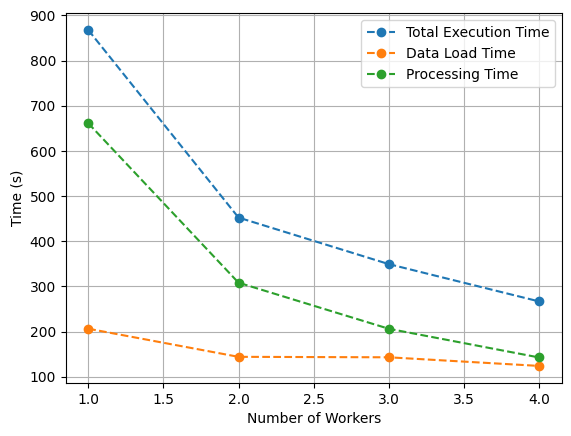

In [10]:
import matplotlib.pyplot as plt

plt.plot(workers, exc_times, 'o--', label="Total Execution Time")
plt.plot(workers, data_load_times, 'o--', label="Data Load Time")
plt.plot(workers, processing_times, 'o--', label="Processing Time")
plt.xlabel("Number of Workers")
plt.ylabel("Time (s)")
plt.legend()
plt.grid()
plt.show()

In [18]:
from scalability_testing import *
execution_time, data_load_time, processing_time = scalability_test(job=sentiment_analysis,
                                                                   num_workers=4)

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 4 workers completed in 206.10 sec
Time to load in data: 63.46 sec
Time to perform data processing task: 142.64 sec


## Weak scalability test
- Proportionally increasing dataset size and resources.
    - 1:  25% of total dataset and 1 worker with 8 cores
    - 2:  50% of total dataset and 2 workers with 8 cores each
    - 3:  50% of total dataset and 4 workers with 8 cores each

In [8]:
exc_times = []
data_load_times = []
processing_times = []
workers = [1, 2, 4]
file_names = ["reddit_25percent.json", "reddit_50percent.json", "corpus-webis-tldr-17.json"]
for num_workers, file in zip(workers, file_names):
    execution_time, data_load_time, processing_time = scalability_test(job=sentiment_analysis,
                                                                       num_workers=num_workers,
                                                                       data_path="hdfs://192.168.2.46:9000/data/"+file
                                                                      )
    exc_times.append(execution_time)
    data_load_times.append(data_load_time)
    processing_times.append(processing_time)

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/03/17 21:15:09 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
25/03/17 21:15:24 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
                                                                                

Test with 1 workers completed in 283.24 sec
Time to load in data: 107.63 sec
Time to perform data processing task: 175.60 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 2 workers completed in 276.18 sec
Time to load in data: 117.74 sec
Time to perform data processing task: 158.45 sec


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
                                                                                

Test with 4 workers completed in 364.92 sec
Time to load in data: 160.58 sec
Time to perform data processing task: 204.34 sec


Took over 1.5 minutes for the two of the executors to start in the last run (with 4 workers), and the times are much greater than the what has been observed in earlier tests with the same settings. Let's substitute those time values with the ones we observed above.

In [9]:
exc_times[-1] = 266.80
data_load_times[-1] = 124.04
processing_times[-1] = 142.76

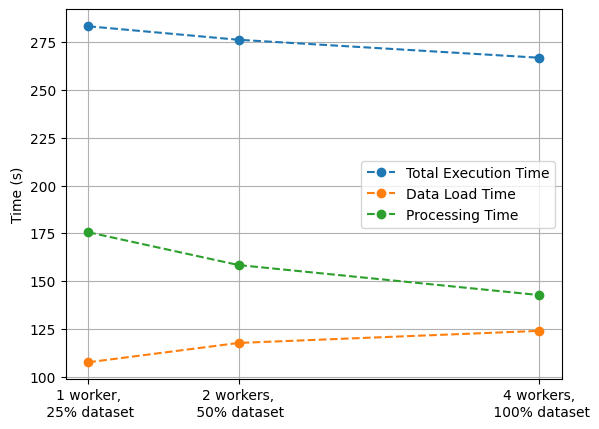

In [17]:
plt.plot(workers, exc_times, 'o--', label="Total Execution Time")
plt.plot(workers, data_load_times, 'o--', label="Data Load Time")
plt.plot(workers, processing_times, 'o--', label="Processing Time")
plt.ylabel("Time (s)")
plt.xticks(ticks=workers, labels=["1 worker,\n 25% dataset", "2 workers,\n 50% dataset", "4 workers,\n 100% dataset"])
plt.legend()
plt.grid()
plt.show()